<a href="https://colab.research.google.com/github/IntrovertInDisguise/iitgn-robotics/blob/main/MidsemBookVignesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Vignesh Ramakrishnan
#21310037
#Importing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
from numpy import sin, cos,arctan,arccos
from collections import deque

In [17]:

#Rotational matrix along x
def RotX(theta):
  theta=np.radians(theta)
  return np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along y
def RotY(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),0,-np.sin(theta),0],[0,1,0,0],[np.sin(theta),0,np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along z
def RotZ(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),-np.sin(theta),0,0],[np.sin(theta),np.cos(theta),0,0],[0,0,1,0],[0,0,0,1]])


#Translational matrix along x
def TransX(dist):
  return np.array([[1,0,0,dist],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

#Translational matrix along y
def TransY(dist):
  return np.array([[1,0,0,0],[0,1,0,dist],[0,0,1,0],[0,0,0,1]])

#Translational matrix along z
def TransZ(dist):
  return np.array([[1,0,0,0],[0,1,0,0],[0,0,1,dist],[0,0,0,1]])
 
#[d,theta,a,alpha]
def AFromDHVals(DH):
  n=np.shape(DH)[0] #From repo, only this index
  A=np.identity(4)
  for i in range(n):
    Anext=TransZ(DH[i][0]) @ RotZ(DH [i][1]) @ RotX(DH [i][3]) @ TransX(DH[i][2]) 
    A=np.matmul(A,Anext)
  return A
#DH=[[0,90,1,0],[0,45,1,0]]
#print(AFromDHVals(DH))



[[-0.70710678 -0.70710678  0.         -0.70710678]
 [ 0.70710678 -0.70710678  0.          1.70710678]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [129]:
#Repository Jacobian1

import numpy as np
import sys
import sympy as sym

class manipulator():

  def __init__(self, no_of_links, type_of_joints, dh_params):
    super().__init__()
    self.no_of_links = no_of_links
    self.type_of_joints = list(type_of_joints)
    self.dh_params = dh_params
    if len(self.dh_params) != self.no_of_links:
      print("ERROR: Please make sure the number of rows in the DH parameters provided is equal to the number of links.")
      sys.exit()
    self.dh_matrices = []
    for i in range(0, self.no_of_links):    
      temp = self.dh_params[i]
      theta = temp[0]
      d = temp[1]
      a = temp[2]
      alpha = temp[3]
      A1 = np.array([[np.cos(theta), -np.sin(theta), 0, 0],[np.sin(theta), np.cos(theta), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A2 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, d],[0, 0, 0, 1]])
      A3 = np.array([[1, 0, 0, a],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A4 = np.array([[1, 0, 0, 0],[0, np.cos(alpha), -np.sin(alpha), 0],[0, np.sin(alpha), np.cos(alpha), 0],[0, 0, 0, 1]])
      A_final = A1@A2@A3@A4
      self.dh_matrices.append(A_final)
    self.dh_matrices = np.array(self.dh_matrices)

    self.transform_matrices = []
    self.rotation_matrices = []

    for i in range(1, self.no_of_links+1):
      temp = self.dh_matrices[0]
      for j in range(1, i):
        temp = temp@self.dh_matrices[j]
      rot_temp = temp
      rot_temp = np.delete(rot_temp, (3), axis = 0)
      rot_temp = np.delete(rot_temp, (3), axis = 1)
      self.transform_matrices.append(temp)
      self.rotation_matrices.append(rot_temp)

    self.transform_matrices = np.array(self.transform_matrices)
    self.rotation_matrices = np.array(self.rotation_matrices)

    self.end_effector_posn = np.delete(self.transform_matrices[len(self.transform_matrices)-1]@np.array([[0],[0],[0],[1]]), (3), axis = 0)

    self.z = []
    self.origins = []
    self.z.append(np.array([[0],[0],[1]]))
    self.origins.append(np.array([[0],[0],[0]]))

    for i in range(0, self.no_of_links):
      temp_z = self.rotation_matrices[i]@np.array([[0],[0],[1]])
      self.z.append(temp_z)
      temp_origin = self.transform_matrices[i]@np.array([[0],[0],[0],[1]])
      temp_origin = np.delete(temp_origin, (3), axis = 0)
      self.origins.append(temp_origin)
    
    self.z = np.array(self.z)
    self.origins = np.array(self.origins)  
    self.jacobian = []
    for i in range(0,self.no_of_links):
      if self.type_of_joints[i] == "R":
        temp_1 = np.cross(self.z[i], self.end_effector_posn-self.origins[i], axis = 0)
        temp_2 = self.z[i]
      if self.type_of_joints[i] == "P":
        temp_1 = self.z[i]
        temp_2 = np.array([[0],[0],[0]])
      temp_jacobian = np.vstack((temp_1, temp_2))
      self.jacobian.append(temp_jacobian)
    self.jacobian = np.array(self.jacobian)
    self.jacobian = self.jacobian.reshape((self.no_of_links,6))
    self.jacobian = np.transpose(self.jacobian)
    self.Jv = np.delete(self.jacobian,(3,4,5), axis = 0)

    print("End Effector Position:")
    print(self.end_effector_posn)
    print("Manipulator Jacobian:")
    print(self.jacobian)
    print("Velocity Jacobian (can be multiplied with qdot to obtain end-effector velocity):")
    print(self.Jv)

my_robot = manipulator(3, "RRR", [[np.pi/3,0,1,0],[0,0,0,np.pi/2],[0,0,0,np.pi/2]])
print("STANFORD MANIPULATOR:")
stanford_manipulator = manipulator(3, "RRP", [[0,0,0,-np.pi/2],[0,2,0,np.pi/2],[0,2,0,0]])
print("SCARA MANIPULATOR:")
SCARA = manipulator(3, "RRP", [[0,0,2,0],[0,0,2,np.pi],[0,2,0,0]])
print("PPP MANIPULATOR:")
PPP = manipulator(3, "PPP", [[0,1,0,-np.pi/2],[-np.pi/2,2,0,-np.pi/2],[0,3,0,0]])
print("6R MANIPULATOR:")
R6 = manipulator(6, "RRRRRR", [[np.pi/2,1,0,-np.pi/2],[0,0,1,0],[0,0,1,np.pi/2],[0,0,0,np.pi/2],[0,0,0,-np.pi/2],[0,1,0,0]])

End Effector Position:
[[0.5      ]
 [0.8660254]
 [0.       ]]
Manipulator Jacobian:
[[-8.66025404e-01  0.00000000e+00 -0.00000000e+00]
 [ 5.00000000e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.66025404e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.00000000e-01]
 [ 1.00000000e+00  1.00000000e+00  6.12323400e-17]]
Velocity Jacobian (can be multiplied with qdot to obtain end-effector velocity):
[[-0.8660254  0.        -0.       ]
 [ 0.5        0.         0.       ]
 [ 0.         0.         0.       ]]
STANFORD MANIPULATOR:
End Effector Position:
[[0.]
 [2.]
 [2.]]
Manipulator Jacobian:
[[-2.000000e+00  2.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]]
Velocity Jacobian (can be multiplied with qdot to obtain end-

# Task 1: Milacron manifold block inspection

In [87]:
Linklengths=[0.25,0.25,0.25]
Linkmasses=[0.8,0.8,0.8]
Amax=[0.45,0.075,0.1]
Bmax=[0.45,-0.075,0.1]
Cmax=[0.25,0.075,0.1]
Dmax=[0.25,-0.075,0.1]

#### Robot 1: Stanford type(RRP)


In [142]:
#Forward Kinematics i.e. end effector positions from joint positions
def For_Pos_Kin_Stanford(jointloc,lengthsoflinks):
  theta1,theta2,dz3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,0,-90],[d2,theta2,0,90],[-dz3,0,0,0]]  
  P0=np.array([0,0,dz3-d1,1])
  A=AFromDHVals(DH)
  return A @ P0


In [148]:
def For_Pos_Kin_Stanford_NoDH(jointloc,lengthsoflinks):
  theta1,theta2,dy2=jointloc[0],jointloc[1],jointloc[2]
  l1,l2,l3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  P2mat = np.transpose(np.array([0,dy2,0,1]))
  P1mat=((RotX(theta2) @ TransX(-l2)) @ P2mat)
  P0mat=((RotZ(theta1) @ TransZ(l1)) @ P1mat)
  return P0mat

In [117]:

#inverse kinematics i.e. joint positions from endeffector positions: My Code
def Inv_Pos_Kin_Stanford(P0,lengthsoflinks):
  P_x=P0[0]
  P_y=P0[1]
  P_z=P0[2]
  l_1,l_2=lengthsoflinks[0],lengthsoflinks[1]
  r= ((P_x**2) + (P_y**2))**0.5 #revolute link radius
  phi= np.arctan2(P_y,P_x) # revolute link angle
 
  theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,((r**2)-(l_2**2))**0.5 ) # theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 ) # also valid

  
  theta_1_v2=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 )
    

  l_hor=((P_x*np.cos(theta_1))+(P_y*np.sin(theta_1))) #Horizontal position of joint 2
  l_vert=l_1-P_z #Vertical position of joint 2



  theta_2=np.arctan2(l_hor,l_vert) #  theta_2=np.arctan2(-l_hor,-l_vert) #also valid

  #if theta_2 < 0 :
  theta_2_v2=np.arctan2(-l_hor,-l_vert)
  
  d_3= (l_hor* np.sin(theta_2))+(l_vert* np.cos(theta_2))
  return [[np.degrees(theta_1),np.degrees(theta_2),d_3],[np.degrees(theta_1_v2),np.degrees(theta_2_v2),d_3]]



jointloc=Inv_Pos_Kin_Stanford(Amax,Linklengths)
print(jointloc)
print(For_Pos_Kin_Stanford(jointloc[1],Linklengths))


[[47.30799649413152, 67.3943310604584, 0.3902320599631367], [-66.23264091018274, -112.6056689395416, 0.3902320599631367]]
[ 0.32181249 -0.11046336  0.34609667  1.        ]


In [125]:
 #From Repository
def invKinStanford_RepoCode(endeffector_position,lengthsoflinks):
    theta1 = np.arctan(endeffector_position[1]/endeffector_position[0])
    r = np.sqrt(endeffector_position[0]**2 + endeffector_position[1]**2)
    s = endeffector_position[2] - lengthsoflinks[0]
    theta2 = np.arctan(s/r)
    d3 = np.sqrt(r**2 + s**2) - lengthsoflinks[1]
    #print("First Solution: \n", "Theta1 = ", theta1, "\n Theta2 =", theta2,"\n Extension: ", d3, "\n")
    #print("Second Solution: \n", "Theta1 = ", np.pi + theta1, "\n Theta2 =", np.pi - theta2,"\n Extension:", d3)
    return [[theta1,theta2,d3],[np.pi + theta1,np.pi - theta2,d3]]
          

inverse_kinematics([30,30,30],[10,10])

array([[ 45.        ,  25.23940182,  36.9041576 ],
       [225.        , 154.76059818,  36.9041576 ]])

#### Robot 2: PUMA type(RRR)

In [ ]:
#Forward Kinematics i.e. end effector positions from joint positions
def For_Pos_Kin_PUMA(jointloc,lengthsoflinks):
  theta1,theta2,theta3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,d2,0],[,theta2,0,90],[-dz3,0,0,0]]
  P0=np.array([0,0,d1-dz3,1])
  A=AFromDHVals(DH)
  return A @ P0

In [140]:
 def Inv_Pos_Kin_PUMA(P0,lengthsoflinks):
   xc,yc,zc=P0[0],P0[1],P0[2]
   l1,l2,l3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
   theta1 = np.rad2deg(np.arctan2(yc,xc))
   D = (xc*xc+yc*yc+(l1-zc)*(l1-zc)-l2*l2-l3*l3)/(2*l2*l3)
   if D>=1 or D<=-1:
     print("singular configuration")
   if D>1 or D<-1:
     print("outside workspace")
   theta3 = (np.arctan2((-np.sqrt(1-D*D)),D))
   theta2 = np.rad2deg(np.arctan2(zc-l1,(np.sqrt(xc*xc+yc*yc)))-np.arctan2((l3*np.sin(theta3)),(l2+l3*np.cos(theta3))))
   theta3 = np.rad2deg(theta3)
   return [[theta1,theta2,theta3]]

print(Inv_Pos_Kin_PUMA([0.05,0.3,0],Linklengths))
jointloc=Inv_Pos_Kin_PUMA([0.5,0,0],Linklengths)
print(For_Pos_Kin_SCARA(jointloc[0],Linklengths))

[[80.53767779197439, -1.3633017452217766, -76.11345963737101]]
singular configuration
outside workspace
[nan nan nan nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
def inverse_kinematics_PUMARepo(l1,l2,l3,xc,yc,zc):
    theta1 = np.rad2deg(math.atan2(yc,xc))
    D = (xc*xc+yc*yc+(l1-zc)*(l1-zc)-l2*l2-l3*l3)/(2*l2*l3)
    if D>=1 or D<=-1:
        print("singular configuration")
    if D>1 or D<-1:
        print("outside workspace")
    theta3 = (math.atan2((-math.sqrt(1-D*D)),D))
    theta2 = np.rad2deg(math.atan2(zc-l1,(math.sqrt(xc*xc+yc*yc)))-math.atan2((l3*math.sin(theta3)),(l2+l3*math.cos(theta3))))
    theta3 = np.rad2deg(theta3)
    return theta1,theta2,theta3

#### Robot 3: SCARA type(RRP)

In [81]:
def For_Pos_Kin_SCARA(jointloc,lengthsoflinks):
  theta1,theta2,dz3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,d2,0],[0,theta2,d3,0],[-dz3,0,0,0]]
  P0=np.array([0,0,d1-dz3,1])
  A=AFromDHVals(DH)
  return A @ P0



In [82]:
 #Inverse Kinematics of SCARA from my old code
 def Inv_Pos_Kin_SCARA(P0,lengthsoflinks):
   l_1=lengthsoflinks[0]
   l_2=lengthsoflinks[1]
   h=lengthsoflinks[2]
   P_x=P0[0]
   P_y=P0[1]
   P_z=P0[2]
   theta_2=np.arccos(((P_x**2+P_y**2)-(l_1**2+l_2**2))/(2*l_1*l_2)) # + or -
   theta_1=np.arctan2(((l_2*P_x*np.sin(theta_2))+P_y*(l_1+l_2*np.cos(theta_2))),(-(l_2*P_y*np.sin(theta_2))+P_x*(l_1+l_2*np.cos(theta_2))))
   d_3=h-P_z
   print()
   return np.array([[np.degrees(theta_1),np.degrees(theta_2),d_3],[np.degrees(theta_1),np.degrees(-theta_2),d_3]])

print(Inv_Pos_Kin_SCARA([0.5,0,0],Linklengths))
jointloc=Inv_Pos_Kin_SCARA([0.5,0,0],Linklengths)
print(For_Pos_Kin_SCARA(jointloc[0],Linklengths))


[[ 0.    0.    0.25]
 [ 0.   -0.    0.25]]

[0.5 0.  0.  1. ]


## Task 1a

In [152]:
Linklengths=[0.25,0.25,0.25]
Linkmasses=[0.8,0.8,0.8]
Amax=[0.45,0.075,0.1]
Bmax=[0.45,-0.075,0.1]
Cmax=[0.25,0.075,0.1]
Dmax=[0.25,-0.075,0.1]

#Calculating required link lengths
def StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1]))
  l3new=( ((l1new-max(abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2])))**2+ (max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1]))))**2 + max(0.25,abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2)**0.5
  return [l1new,l2new,l3new]
print('Stanford Link lengths required:',StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lstan=StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax)



def SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=(max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))
  l3new=((max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))**2 + max(abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2-l2new**2)**0.5
  return [l1new,l2new,l3new]
print('SCARA Link lengths required:',SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lScara=SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax)




def PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=(max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))
  l3new=((max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))**2 + max(abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2+(l1new-max(abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2])))**2-l2new**2)**0.5
  return [l1new,l2new,l3new]
print('PUMA Link lengths required:',PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lPUMA=PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax)

#Verification
jointloc=invKinStanford_RepoCode(Amax,lstan)
#print(jointloc)
print(For_Pos_Kin_Stanford_NoDH(jointloc[0],lstan))



Stanford Link lengths required: [0.25, 0.25, 0.48192971479252034]
SCARA Link lengths required: [0.25, 0.25, 0.4031128874149275]
PUMA Link lengths required: [0.25, 0.25, 0.4301162633521313]
[-0.25066258  0.22950923  0.24872353  1.        ]


## Task 1b

## Task 1c


## Task 1d

## Task 1e

##Task 3b

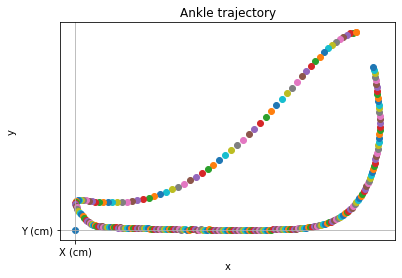

In [178]:
import xlrd
loc = ("/content/drive/MyDrive/Colab Notebooks/Gait_DATA.xlsx")
 
wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)
for i in range(sheet.nrows):
  p=sheet.row_values(i)
  plt.scatter(p[0],p[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ankle trajectory')
plt.grid()
plt.show()